In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class EEGDataset(Dataset):
    def __init__(self, dataframe, scaler=None, fit_scaler=False):
        self.labels = dataframe['Label'].values
        # delete non-feature columns
        feature_cols = [c for c in dataframe.columns if c not in ['Subject_ID', 'Label', 'Unnamed: 0']]
        self.features = dataframe[feature_cols].values.astype(np.float32)
        
        if fit_scaler:
            self.scaler = StandardScaler()
            self.features = self.scaler.fit_transform(self.features)
        elif scaler is not None:
            self.scaler = scaler
            self.features = self.scaler.transform(self.features)
        else:
            self.scaler = None

    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

def load_binary_data(disease_path, control_path):
    """ Binary the labels (1=Disease, 0=Control)"""
    # 1. Load CSV
    dis_df = pd.read_csv(disease_path)
    con_df = pd.read_csv(control_path)
    
    # 2. Force Binary Labels
    dis_df['Label'] = 1
    con_df['Label'] = 0
    
    # 3. Split by Subject
    def split_groups(df, train_ratio=0.7):
        splitter = GroupShuffleSplit(n_splits=1, train_size=train_ratio, random_state=42)
        train_idx, test_idx = next(splitter.split(df, groups=df['Subject_ID']))
        return df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

    dis_train, dis_test = split_groups(dis_df)
    con_train, con_test = split_groups(con_df)

    # 4. Combine
    train_df = pd.concat([dis_train, con_train], ignore_index=True)
    test_df = pd.concat([dis_test, con_test], ignore_index=True)
    
    return train_df, test_df

In [39]:
class DeepMLP(nn.Module):
    def __init__(self, input_size=95, num_classes=2, dropout_rate=0.3):
        super(DeepMLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.output = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x
model_name = "DeepMLP"

In [ ]:
def train_and_save(train_df, test_df, task_name, save_path):
    # Prepare Data
    train_dataset = EEGDataset(train_df, fit_scaler=True)
    test_dataset = EEGDataset(test_df, scaler=train_dataset.scaler)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # Init Model
    model = DeepMLP(input_size=95, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    
    print(f"🚀 Training {task_name}...")
    for epoch in range(30): # 30 Epochs
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/30], Loss: {loss.item():.4f}")
            
    # Save Model Weights
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved to: {save_path}")
    
    return train_dataset.scaler

In [ ]:
def evaluate_saved_model(test_df, model_path, scaler, task_name):
    print(f"\n📊 Evaluating {task_name} using {model_path}...")
    
    # 1. Prepare Data using loaded Scaler
    test_dataset = EEGDataset(test_df, scaler=scaler)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # 2. Load Model
    model = DeepMLP(input_size=95, num_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # 3. Predict Epochs
    y_pred_epochs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred_epochs.extend(predicted.cpu().numpy())
            
    # 4. Subject-level Voting
    results_df = pd.DataFrame({
        'Subject_ID': test_df['Subject_ID'],
        'True_Label': test_df['Label'],
        'Pred_Label': y_pred_epochs
    })
    
    subj_true = []
    subj_pred = []
    
    for subject in results_df['Subject_ID'].unique():
        subj_data = results_df[results_df['Subject_ID'] == subject]
        true_lab = subj_data['True_Label'].iloc[0]
        pred_lab = subj_data['Pred_Label'].mode()[0]
        subj_true.append(true_lab)
        subj_pred.append(pred_lab)
        
    # 5. Calculate Metrics (Research Style)
    cm = confusion_matrix(subj_true, subj_pred)
    # Binary: TN(0,0), FP(0,1), FN(1,0), TP(1,1)
    # 0=Control, 1=Disease
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn=fp=fn=tp=0 #In case of all predictions are of one class, confusion_matrix returns a 1x1 matrix.
        
    acc = accuracy_score(subj_true, subj_pred) * 100
    sens = (tp / (tp + fn) * 100) if (tp+fn) > 0 else 0 # Recall of Disease
    spec = (tn / (tn + fp) * 100) if (tn+fp) > 0 else 0 # Recall of Control
    f1 = f1_score(subj_true, subj_pred) * 100
    
    print(f"{'-'*30}")
    print(f"Accuracy (ACC):    {acc:.2f}%")
    print(f"Sensitivity (SENS): {sens:.2f}% (Disease)")
    print(f"Specificity (SPEC): {spec:.2f}% (Control)")
    print(f"F1 Score (F1):     {f1:.2f}%")
    print(f"{'-'*30}")
    print(f"Confusion Matrix (Subject-level):")
    
    # Plot CM
    plt.figure(figsize=(4, 3))
    target_names = ['Control', task_name.split()[0]]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{task_name} Results')
    plt.show()

In [ ]:
# --- Task A: AD vs CN ---
# 1. Data Loading
#train_df_ad, test_df_ad = load_binary_data('features/AD_features.csv', 'features/CN_features.csv')
# 2. Train and Save Scaler for Evaluation
#scaler_ad = train_and_save(train_df_ad, test_df_ad, "AD vs CN", f"save_model/ad_c_{model_name}.pth")

# --- Task B: FTD vs CN ---
#train_df_ftd, test_df_ftd = load_binary_data('features/FTD_features.csv', 'features/CN_features.csv')
#scaler_ftd = train_and_save(train_df_ftd, test_df_ftd, "FTD vs CN", f"save_model/ftd_c_{model_name}.pth")

🚀 Training AD vs CN...
Epoch [1/30], Loss: 0.5895
Epoch [2/30], Loss: 0.4096
Epoch [3/30], Loss: 0.2649
Epoch [4/30], Loss: 0.3740
Epoch [5/30], Loss: 0.3486
Epoch [6/30], Loss: 0.2361
Epoch [7/30], Loss: 0.2139
Epoch [8/30], Loss: 0.3612
Epoch [9/30], Loss: 0.2152
Epoch [10/30], Loss: 0.2821
Epoch [11/30], Loss: 0.4786
Epoch [12/30], Loss: 0.3496
Epoch [13/30], Loss: 0.1644
Epoch [14/30], Loss: 0.2681
Epoch [15/30], Loss: 0.1604
Epoch [16/30], Loss: 0.2940
Epoch [17/30], Loss: 0.1546
Epoch [18/30], Loss: 0.4241
Epoch [19/30], Loss: 0.2612
Epoch [20/30], Loss: 0.1848
Epoch [21/30], Loss: 0.1961
Epoch [22/30], Loss: 0.2119
Epoch [23/30], Loss: 0.2318
Epoch [24/30], Loss: 0.3130
Epoch [25/30], Loss: 0.2318
Epoch [26/30], Loss: 0.3512
Epoch [27/30], Loss: 0.1390
Epoch [28/30], Loss: 0.2312
Epoch [29/30], Loss: 0.1190
Epoch [30/30], Loss: 0.1718
✅ Model saved to: save_model/ad_c_DeepMLP_adjusted.pth



📊 Evaluating AD vs CN using save_model/ad_c_DeepMLP_adjusted.pth...
------------------------------
Accuracy (ACC):    80.00%
Sensitivity (SENS): 72.73% (Disease)
Specificity (SPEC): 88.89% (Control)
F1 Score (F1):     80.00%
------------------------------
Confusion Matrix (Subject-level):


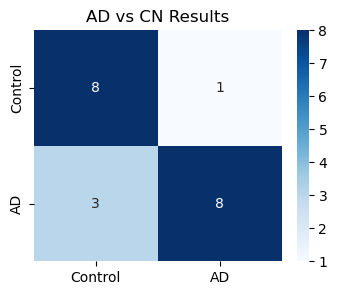

In [ ]:
# Evalulation AD vs CN
#evaluate_saved_model(test_df_ad, "save_model/ad_c_DeepMLP.pth", scaler_ad, "AD vs CN")

#Evalulation FTD vs CN
#evaluate_saved_model(test_df_ftd, "save_model/ftd_c_DeepMLP.pth", scaler_ftd, "FTD vs CN")